In [35]:
import numpy as np
import pandas as pd
import os
import re
import csv
from datetime import datetime
from gensim.models import word2vec
from sklearn.metrics import log_loss
import lightgbm as lgb 
#from pylightgbm.models import GBMRegressor
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
import json
import operator
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
import seaborn as sns
%matplotlib inline
p = sns.color_palette()
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_colwidth', 500)

In [3]:
smile_data=pd.read_csv('smile_data.csv',index_col=False)

In [4]:
smile_data.head()

,smiles,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]3CC[C@@]21C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [5]:

smile_data_copy=smile_data[["smiles","target1"]]

mol=smile_data['smiles']

In [6]:
smile_data_copy['smiles_lst']=smile_data_copy['smiles'].apply(lambda x:' '.join(list(x)))

E:\program_files\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
smile_data_copy.head()

,smiles,target1,smiles_lst
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,C C O c 1 c c c 2 n c ( S ( N ) ( = O ) = O ) s c 2 c 1
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,C C N 1 C ( = O ) N C ( c 2 c c c c c 2 ) C 1 = O
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]3CC[C@@]21C,NaN,C C [ C @ ] 1 ( O ) C C [ C @ H ] 2 [ C @ @ H ] 3 C C C 4 = C C C C [ C @ @ H ] 4 [ C @ H ] 3 C C [ C @ @ ] 2 1 C
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,C C C N ( C C ) C ( C C ) C ( = O ) N c 1 c ( C ) c c c c 1 C
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,C C ( O ) ( P ( = O ) ( O ) O ) P ( = O ) ( O ) O


In [8]:
smile_data_copy_1col=pd.DataFrame(data=smile_data_copy,columns=['smiles_lst'])

In [9]:
smile_data_copy_1col.to_csv("whole_sens",index=None,header=False,sep=" ",quoting=csv.QUOTE_NONE,escapechar=' ')

In [10]:
sent=word2vec.Text8Corpus("whole_sens")

In [11]:
model=word2vec.Word2Vec(sent,seed=12345,min_count=1,size=300,sg=1,hs=1,negative=0,window=3)

In [12]:
model

In [13]:
model.wv.save_word2vec_format('vect2.txt',binary=False)

In [14]:
text_in=pd.read_csv("vect2.txt",sep=" ",header=None,skiprows=1)

In [15]:
text_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Columns: 301 entries, 0 to 300
dtypes: float64(300), object(1)
memory usage: 129.5+ KB


In [16]:
text_in.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,C,0.021249,-0.039138,-0.023565,-0.020411,0.014457,-0.046241,0.032582,-0.078275,-0.013152,...,-0.024244,-0.058358,0.069463,-0.103408,0.114393,-0.086775,-0.026695,-0.003962,0.000108,0.047632
1,c,-0.033819,-0.166030,0.115523,-0.082055,0.079620,0.072239,0.086054,0.002445,-0.092627,...,0.003841,-0.013588,0.130805,-0.074952,-0.005002,-0.097959,-0.016400,0.003133,0.018772,0.107459
2,(,-0.015986,-0.071259,-0.004369,0.039811,-0.015667,0.021118,0.028283,-0.114286,-0.001057,...,0.017115,-0.032094,0.161371,-0.010527,0.012317,-0.003661,0.005500,-0.046365,-0.011410,0.063955
3,),-0.070343,-0.046699,-0.038827,0.011962,-0.019679,-0.049733,0.039914,-0.115628,-0.100795,...,0.000232,-0.061472,0.111419,-0.080233,0.049187,-0.130655,0.001436,0.025836,-0.012069,0.073656
4,O,-0.021961,-0.042765,-0.029316,-0.025256,-0.051876,0.061553,0.018829,-0.056633,0.025778,...,-0.011224,-0.003212,0.090732,0.023007,0.098610,-0.031857,-0.030939,-0.048088,0.012134,0.009352


In [17]:
text_in_t=text_in.transpose()

In [18]:
text_in_t.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,C,c,(,),O,1,=,@,[,],...,9,T,K,G,t,L,V,Y,D,y
1,0.0212486,-0.0338194,-0.0159857,-0.0703435,-0.0219609,0.00589899,-0.0831808,-0.0697621,-0.00181138,-0.0120645,...,-0.0605763,-0.0682282,-0.0975258,-0.114369,-0.0496859,-0.105859,-0.00855572,-0.0346238,-0.0318024,-0.0264416
2,-0.0391377,-0.16603,-0.0712591,-0.0466985,-0.0427646,-0.159676,0.00681231,0.0575595,0.0464064,-0.00117008,...,-0.0346529,-0.0439397,-0.0137738,-0.0264356,-0.0392514,-0.0313538,-0.0194593,-0.0353517,-0.0241347,-0.0293508
3,-0.023565,0.115523,-0.00436897,-0.0388273,-0.0293164,0.05369,0.00407944,-0.0494675,0.042266,0.0197482,...,-0.0303707,-0.0126085,0.0266848,0.00470103,0.000289922,0.00673838,0.000201338,0.00860729,0.000241651,0.00843442
4,-0.0204108,-0.0820555,0.0398108,0.0119622,-0.0252556,-0.016181,-0.0397025,0.00215265,0.0543507,-0.0574949,...,-0.0265426,-0.0855965,-0.0687234,-0.0770295,-0.0503959,-0.0831339,-0.0140168,-0.0357301,-0.0247995,-0.0227604


In [19]:
text_in_t.columns = text_in_t.iloc[0]

In [20]:
text_in_t.reindex(text_in_t.index.drop(0)).head()

,C,c,(,),O,1,=,@,[,],...,9,T,K,G,t,L,V,Y,D,y
1,0.0212486,-0.0338194,-0.0159857,-0.0703435,-0.0219609,0.00589899,-0.0831808,-0.0697621,-0.00181138,-0.0120645,...,-0.0605763,-0.0682282,-0.0975258,-0.114369,-0.0496859,-0.105859,-0.00855572,-0.0346238,-0.0318024,-0.0264416
2,-0.0391377,-0.16603,-0.0712591,-0.0466985,-0.0427646,-0.159676,0.00681231,0.0575595,0.0464064,-0.00117008,...,-0.0346529,-0.0439397,-0.0137738,-0.0264356,-0.0392514,-0.0313538,-0.0194593,-0.0353517,-0.0241347,-0.0293508
3,-0.023565,0.115523,-0.00436897,-0.0388273,-0.0293164,0.05369,0.00407944,-0.0494675,0.042266,0.0197482,...,-0.0303707,-0.0126085,0.0266848,0.00470103,0.000289922,0.00673838,0.000201338,0.00860729,0.000241651,0.00843442
4,-0.0204108,-0.0820555,0.0398108,0.0119622,-0.0252556,-0.016181,-0.0397025,0.00215265,0.0543507,-0.0574949,...,-0.0265426,-0.0855965,-0.0687234,-0.0770295,-0.0503959,-0.0831339,-0.0140168,-0.0357301,-0.0247995,-0.0227604
5,0.0144568,0.0796201,-0.0156666,-0.0196793,-0.0518762,-0.0470745,0.0166353,-0.0416263,-0.0597807,-0.052926,...,0.0190409,0.0141404,0.03696,0.0245563,0.0102487,0.0323307,-0.00374026,0.00852855,0.00324954,-0.00226659


In [21]:
text_in_t_clmn=text_in_t.reindex(text_in_t.index.drop(0))

In [22]:
text_in_t_clmn_dict=text_in_t_clmn.to_dict(orient='list')

In [23]:


def add_lst(chek_lst):
    zarray = np.zeros(300)
    for elment in str(chek_lst).split(" "):
        zarray+=text_in_t_clmn_dict[elment]
    return np.array(zarray)

In [24]:
smile_data_copy['smiles_lst_vect_sum']=smile_data_copy['smiles_lst'].apply(add_lst)

E:\program_files\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df1=pd.DataFrame(smile_data_copy['smiles_lst_vect_sum'].values.tolist())

In [26]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.061439,-2.759840,1.032160,-1.403485,0.292298,0.990291,1.306444,-0.900524,-0.935839,-0.058056,...,0.059608,-0.930291,2.854904,-1.302563,0.933606,-1.612438,-0.372957,-0.488423,0.185530,1.476938
1,-0.484091,-2.186369,0.739039,-0.989340,0.368259,0.545904,1.066452,-1.069149,-0.747616,-0.079860,...,-0.229402,-1.140328,2.374218,-1.512783,0.858280,-1.463538,-0.551989,-0.349685,0.029339,1.323360
2,-1.077046,-1.433668,-1.156120,-1.025921,-1.075294,-0.997828,1.301105,-5.245577,-3.388162,-0.686819,...,-1.475589,-2.079378,0.059299,-6.958743,3.653766,-3.493527,-0.148453,0.080056,1.494801,1.168868
3,-0.351587,-2.343965,0.440780,-0.797266,0.496389,0.015162,1.358883,-1.897883,-1.006255,-0.116707,...,-0.341283,-1.535004,3.122091,-2.292836,1.591923,-2.241099,-0.645060,-0.244280,-0.020494,1.875106
4,-1.058361,-1.038855,-0.407096,-0.131860,-0.514722,0.296031,0.679083,-1.318405,-0.203833,-0.021339,...,-0.208093,-0.874782,2.449161,-0.536244,1.503996,-1.125842,-0.269895,-0.697065,-0.256653,0.856140


In [27]:
smile_data_copy_label = smile_data_copy.drop(smile_data_copy.columns[[0,2,3]], axis=1) 

In [28]:
smile_data_copy_label_feat_combine=pd.concat([smile_data_copy_label,df1],axis=1)

In [29]:
smile_data_copy_label_feat_combine_nomiss=smile_data_copy_label_feat_combine.dropna(how='any')

In [30]:
df=smile_data_copy_label_feat_combine_nomiss

In [31]:
df.columns = df.columns.astype(str)

In [33]:
df.head()

,target1,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0.0,-1.061439,-2.759840,1.032160,-1.403485,0.292298,0.990291,1.306444,-0.900524,-0.935839,...,0.059608,-0.930291,2.854904,-1.302563,0.933606,-1.612438,-0.372957,-0.488423,0.185530,1.476938
1,0.0,-0.484091,-2.186369,0.739039,-0.989340,0.368259,0.545904,1.066452,-1.069149,-0.747616,...,-0.229402,-1.140328,2.374218,-1.512783,0.858280,-1.463538,-0.551989,-0.349685,0.029339,1.323360
3,0.0,-0.351587,-2.343965,0.440780,-0.797266,0.496389,0.015162,1.358883,-1.897883,-1.006255,...,-0.341283,-1.535004,3.122091,-2.292836,1.591923,-2.241099,-0.645060,-0.244280,-0.020494,1.875106
4,0.0,-1.058361,-1.038855,-0.407096,-0.131860,-0.514722,0.296031,0.679083,-1.318405,-0.203833,...,-0.208093,-0.874782,2.449161,-0.536244,1.503996,-1.125842,-0.269895,-0.697065,-0.256653,0.856140
5,0.0,-0.438499,-1.740924,-0.839876,-0.013412,-0.258964,-0.722562,1.142215,-3.318251,-0.922125,...,-0.294017,-1.695097,3.656655,-2.288585,2.716761,-2.590360,-0.495383,-0.419967,-0.137562,1.900404


In [42]:
trains=df
tests=df

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
import seaborn as sns
def kfold_lightgbm(train_df,test_df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    print("Starting LightGBM. Train shape: {}  Test shape: {} ".format(train_df.shape,test_df.shape))
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['target1']]
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target1'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['target1'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['target1'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 60,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 1,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 60, # 39.3259775,
            'seed': 0,
            'verbose': -1,
            'metric': 'auc'
               
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=500,
            verbose_eval=False
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits
       # print("xxx",sub_preds)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        fold_importance_df=fold_importance_df.sort_values(["importance"],ascending=False)
        fold_importance_df.to_csv('feature_importance%i.csv'%(n_fold+1),index=False)
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1,  roc_auc_score(dvalid.label,oof_preds[valid_idx])))
        clf.save_model('InVivo_Lgbm%2d.model'%(n_fold+1))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['target1'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['prediction']=sub_preds
        print(sub_preds)
        
        sub_df =test_df
        sub_df['prediction']=test_df['prediction']
        sub_df[['prediction']].to_csv('d1.csv', index=0,encoding='GBK')
        fold_importance_df=fold_importance_df.sort_values(["importance"],ascending=False)
        fold_importance_df.to_csv("feature_importance_risk.csv",index=False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [61]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances02.png')

Starting LightGBM. Train shape: (7439, 302)  Test shape: (7439, 302) 
Fold  1 AUC : 0.869870
Fold  2 AUC : 0.846725
Fold  3 AUC : 0.854272
Fold  4 AUC : 0.889025
Fold  5 AUC : 0.831698
Full AUC score 0.848122
[0.02543773 0.01933737 0.01628426 ... 0.31021193 0.26398432 0.03367993]


E:\program_files\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\program_files\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,feature,importance,fold
300,prediction,8839.473386,1
75,75,205.671299,1
246,246,191.952523,1
33,33,134.647297,1
81,81,125.414571,1
79,79,117.521839,1
261,261,108.391998,1
64,64,105.739799,1
298,298,101.338001,1
275,275,79.861610,1


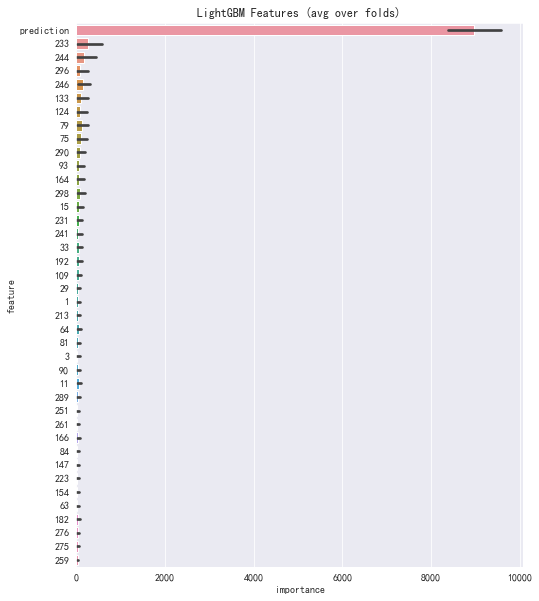

In [62]:
kfold_lightgbm(trains,tests,5, stratified = False, debug= False)